# Here, I will analyze the saved study

In [35]:
import joblib
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras import layers
import optuna

import matplotlib.pyplot as plt

### Setting Up GPU as a training device

In [36]:
physical_devices = tf.config.list_physical_devices()

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [37]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

### Loading Data

In [38]:
N_TRAIN_EXAMPLES = 50000
N_TEST_EXAMPLES = 10000

CLASSES=10

In [39]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

import numpy as np
from sklearn.model_selection import train_test_split

# Concatenate train and test images
X = np.concatenate((X_train, X_test))
y = np.concatenate((Y_train, Y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=N_TRAIN_EXAMPLES, test_size=N_TEST_EXAMPLES, random_state=1)

# Getting dummy variables
y_train_fixed = np.zeros((y_train.shape[0], 10))
y_test_fixed = np.zeros((y_test.shape[0], 10))

i = 0
for [val] in y_train:
  y_train_fixed[i][val] = 1
  i += 1
  
i = 0
for [val] in y_test:
  y_test_fixed[i][val] = 1
  i += 1

### Loading study

In [40]:
study = joblib.load('optuna_study_saving_test.pkl')

print(study.best_params)
print(study.best_value)

{'filters_1': 64, 'kernel_size_1': 3, 'filters_2': 64, 'kernel_size_2': 5, 'strides_2': 1, 'max_pool_size_1': 3, 'dense_size_1': 256, 'learning_rate': 8.253374315877225e-05}
0.6603999733924866


### Building model

In [41]:
model = keras.Sequential(
  [
    keras.Input(shape=(32, 32, 3)),
    layers.Conv2D(64, kernel_size=3, padding='same', activation="relu"),
    layers.Dropout(0.1),
    layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation="relu"),
    layers.Dropout(0.1),
    layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation="relu"),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=3),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(CLASSES, activation="softmax"),
  ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 dropout_20 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 dropout_21 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)        102464    
                                                                 
 dropout_22 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)        

In [42]:
optimizer = keras.optimizers.Adam()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [43]:
%%time
batch_size = 256
epochs = 20
validation_split = 0.2
history = model.fit(X_train, y_train_fixed, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/20
157/157 [==============================] - 8s 44ms/step - loss: 3.3388 - accuracy: 0.2546 - val_loss: 1.7593 - val_accuracy: 0.3626
Epoch 2/20
157/157 [==============================] - 7s 42ms/step - loss: 1.6943 - accuracy: 0.3845 - val_loss: 1.5878 - val_accuracy: 0.4449
Epoch 3/20
157/157 [==============================] - 7s 42ms/step - loss: 1.5211 - accuracy: 0.4523 - val_loss: 1.4160 - val_accuracy: 0.4980
Epoch 4/20
157/157 [==============================] - 7s 42ms/step - loss: 1.3976 - accuracy: 0.5037 - val_loss: 1.2880 - val_accuracy: 0.5433
Epoch 5/20
157/157 [==============================] - 7s 42ms/step - loss: 1.2980 - accuracy: 0.5366 - val_loss: 1.2719 - val_accuracy: 0.5607
Epoch 6/20
157/157 [==============================] - 7s 42ms/step - loss: 1.2274 - accuracy: 0.5662 - val_loss: 1.1772 - val_accuracy: 0.5956
Epoch 7/20
157/157 [==============================] - 7s 42ms/step - loss: 1.1634 - accuracy: 0.5878 - val_loss: 1.1222 - val_accuracy: 0.6081

Text(0.5, 1.0, 'Loss Curves')

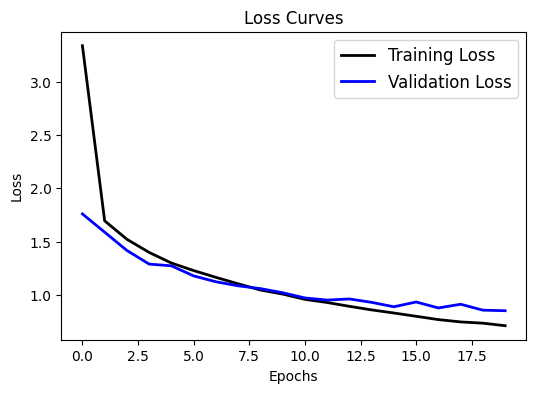

In [44]:
# Plotting the loss curve
plt.figure(figsize=[6, 4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

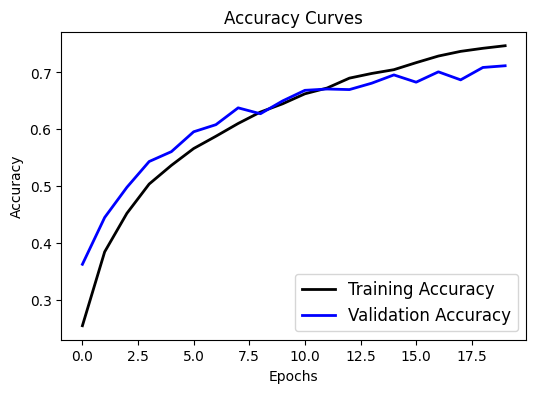

In [45]:
# Plotting the accuracy curve
plt.figure(figsize=[6, 4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)